In [1]:
import numpy as np
from array import array
from pydub import AudioSegment
from scipy.fft import rfft, rfftfreq
from scipy.signal import filtfilt, butter
from scipy.signal.windows import hamming

In [2]:
# Парсим pydub AudioSegment в numpy массив уровней квантизации. Массив может состоять из 1 стобца(канала) при моно звуке и из 2 столбцов(каналов) при стерео
def pydub_to_np(audio: AudioSegment) -> np.ndarray:
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels))

# Трансформирует стерео звук в моно, вычисляя среднее между левым и правым каналом. dtype = int чтобы округлить до нижнего уровня
def stereo_to_mono(stereo: np.ndarray) -> np.ndarray:
    return np.mean(stereo, axis = 1, dtype=int)

def butter_lowpass(cutoff, frame_rate, order=5):
    nyq = 0.5 * frame_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, frame_rate, order=5) -> np.ndarray:
    b, a = butter_lowpass(cutoff, frame_rate, order=order)
    return filtfilt(b, a, data).astype(int)

def downsampling(data, by: int = 4):
    return data[::by]

# Генератор, возвращает чанк из n элементов
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_windowed_fft_result(data, frame_rate: int, window_size: int, window_func = hamming) -> (list, list[list]):
    y_freq = []
    w = window_func(window_size)
    for chunk in chunks(data, window_size):
        if len(chunk) != window_size:
            break

        windowed_chunk = chunk * w
        fft_res = np.abs(rfft(windowed_chunk))

        y_freq.append(fft_res)

    bins = rfftfreq(window_size, d = 1 / frame_rate)

    return bins, y_freq


In [3]:
sound = AudioSegment.from_mp3("/home/araxal/harddrive/fma_small/test/44.mp3")

In [4]:
frame_rate = sound.frame_rate
sample_width = sound.sample_width ## квантизация (в байтах)
downsample_by = 4
downsampled_frame_rate = frame_rate / downsample_by
cutoff_frequency = downsampled_frame_rate / 2 ## nyquist

window_size = 1024

In [5]:
mono_sound = stereo_to_mono(pydub_to_np(sound))

In [6]:
AudioSegment(array(sound.array_type, mono_sound), channels=1, sample_width=sample_width, frame_rate=44100)

In [7]:
filtered_sound = lowpass_filter(mono_sound, cutoff_frequency, frame_rate, order=5);

In [8]:
AudioSegment(array(sound.array_type, filtered_sound), channels=1, sample_width=sample_width, frame_rate=44100)

In [9]:
downsampled_sound = downsampling(filtered_sound, downsample_by)

In [10]:
AudioSegment(array(sound.array_type, downsampled_sound), channels=1, sample_width=sample_width, frame_rate=downsampled_frame_rate)

In [11]:
bins, y_freq = get_windowed_fft_result(downsampled_sound, downsampled_frame_rate, window_size)

In [12]:
def compute_most_powerful_bin_indices(samples, bin_groups = ((0, 10),(10, 20),(20, 40),(40, 80),(80, 160),(160, 513))) -> list:
    result = []
    for sample in samples:
        bins = []
        for (min_bin, max_bin) in bin_groups:
            interval = sample[min_bin:max_bin]
            (m,i) = max((v,i) for i,v in enumerate(interval))

            bins.append((m,i))

        result.append(bins)

    # Фильтруем бины, которые больше чем среднее максимальных бинов
    bin_mean = np.mean([item[0] for sublist in result for item in sublist])

    for idx, beans in enumerate(result):
        result[idx] = list(map(lambda el: el[1], filter(lambda el: el[0] >= bin_mean, beans)))

    return result

In [13]:
%%time
most_powerful_bin_indices = compute_most_powerful_bin_indices(y_freq)

CPU times: user 3.6 ms, sys: 111 µs, total: 3.71 ms
Wall time: 3.72 ms


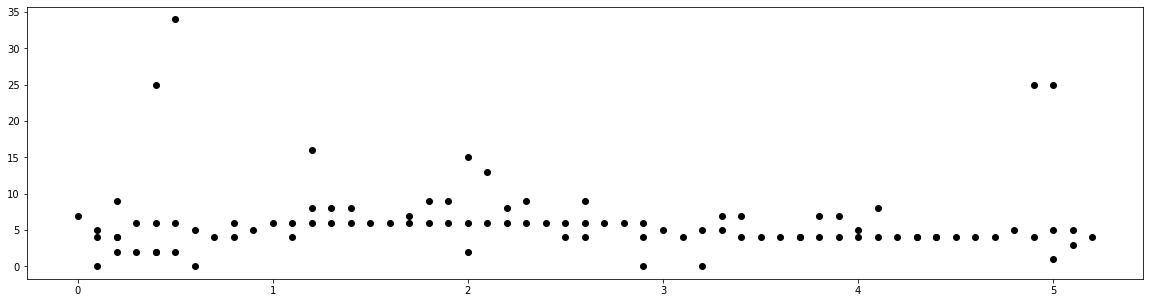

In [14]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
for idx, time in enumerate(most_powerful_bin_indices):
    for bin in time:
        plt.scatter(idx * 0.1, bin, c = 'k')

plt.show()

In [15]:
def get_flatten_bin_indices(data):
    transformed = []
    for time_idx, bins in enumerate(data):
        for bin in bins:
            transformed.append((time_idx, bin))
    return transformed

In [16]:
transformed = get_flatten_bin_indices(most_powerful_bin_indices)

In [17]:
def get_target_zones(data, target_zone_length = 5):
    groups = []
    for i in range(0, len(data) - target_zone_length + 1):
        groups.append(data[i: i + 5])
    return groups

def get_target_zones_with_anchors(data, target_zone_length = 5, anchor_shift = 3):
    target_zones = get_target_zones(data, target_zone_length = target_zone_length)
    result = []

    for i in range(0, len(data) - target_zone_length + 1 - anchor_shift):
        point = data[i]
        result.append((point, target_zones[i + 3]))
    return result

In [18]:
target_zones = get_target_zones_with_anchors(transformed)

In [19]:
def get_structure_to_unwind(target_zones, song_id = 1):
    result = []
    for zone in target_zones:
        anchor_time = zone[0][0]
        anchor_freq = zone[0][1]

        first = (anchor_time, song_id)

        second = []

        for point in zone[1]:
            second.append((anchor_freq, point[1], point[0] - anchor_time))

        result.append((first, second))
    return result

In [20]:
structure_to_unwind = get_structure_to_unwind(target_zones)

In [21]:
from collections import defaultdict
def get_hash_map(unwind_structure):
    hash_map = defaultdict(list)

    for zone in unwind_structure:
        for point in zone[1]:
            hash_map[point].append(zone[0])
    return hash_map

In [22]:
hash_map = get_hash_map(structure_to_unwind)
hash_map[(4,4,1)]

[(1, 1), (43, 1)]

# поиск

In [23]:
part_of_sound = downsampled_sound[50000:200000]

In [24]:
AudioSegment(array(sound.array_type, part_of_sound), channels=1, sample_width=sample_width, frame_rate=downsampled_frame_rate)

In [25]:
def perform_algo(sound, frame_rate, window_size):
    bins, y_freq = get_windowed_fft_result(sound, frame_rate, window_size)
    most_powerful_bin_indices = compute_most_powerful_bin_indices(y_freq)
    transformed = get_flatten_bin_indices(most_powerful_bin_indices)
    target_zones = get_target_zones_with_anchors(transformed)
    structure_to_unwind = get_structure_to_unwind(target_zones)
    return structure_to_unwind

In [26]:
part_of_algo = perform_algo(part_of_sound, downsampled_frame_rate, window_size)

In [27]:
hm = defaultdict(int)

for (x, y) in part_of_algo:
    for point in y:
        if point in hash_map:
            for z in hash_map[point]:
                hm[z] += 1

In [28]:
len(part_of_algo), len(structure_to_unwind), len(hm)

(0, 91, 0)

In [29]:
filtered_hm = {  k: hm[k] for k in hm.keys() if hm[k] >= 4 }

In [30]:
len(filtered_hm)

0

In [31]:
song_counts = defaultdict(int)

for (time, song_id) in filtered_hm.keys():
    song_counts[song_id] += 1

In [32]:
song_counts

defaultdict(int, {})

In [33]:
coef = 0.9
filter_threshold = coef * len(part_of_algo)

filtered_song_counts = {  k: song_counts[k] for k in song_counts.keys() if song_counts[k] >= filter_threshold }
filtered_song_counts

{}

In [34]:
part_of_algo

[]

In [35]:
deltas = defaultdict(int)

for (time, useless), points in part_of_algo:
    for point in points:
        song_times = hash_map[point]
        for (song_time, song_id) in song_times:
            deltas[time - song_time] += 1

# dict(sorted(deltas.items(), key = lambda item: item[1], reverse=True))
max(deltas.values())

ValueError: max() arg is an empty sequence

In [ ]:
counter = 0
for (unused, points) in part_of_algo:
    for point in points:
        counter += 1

counter